# Design distal enhancer toward monocyte-specific PPIF expression

In [40]:
import pandas as pd
import bioframe as bf
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import grelu.resources
import grelu.visualize

### Coordinates at locus

Coordinates: PPIF locus (hg19 chr10:81,037,448-81,124,761), PPIF enhancer (chr10:81,045,48981,047,143), PPIF promoter (chr10:81,106,967-81,107,535).  

**_hg19_**
- chr10:81037448-81124761 (locus)
- chr10:81045489-81047143 (enhancer)
- chr10:81106967-81107535 (promoter) : 569 bp

**_hg38_**
- chr10:79277691-79365005 (locus)
- chr10:79285732-79287386 (enhancer)
- chr10:79347211-79347779 (promoter): conversion seems correct

### Load model

In [2]:
model = grelu.resources.load_model(
    project="borzoi",
    alias="latest",
    model_name="human_fold0" 
)

wandb: Currently logged in as: lgunsalus (grelu). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_fold0:latest, 711.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


## Get experimental data from borzoi training data

### Define plotting intervals

In [10]:
chrom = 'chr10'

enhancer_start = 79285732
enhancer_end = 79287386

# region to plot
plotting_buffer = 10000

chrom = 'chr10'
promoter_start = 79347211
promoter_end = 79347779
query_interval = pd.DataFrame({'chrom':[chrom], 'start':[promoter_start - plotting_buffer], 'end':[promoter_end + plotting_buffer], "strand":["+"],})


### Functionality to pull borzoi training data

In [3]:

def get_seq_mapping(file_path='/gstore/data/resbioai/grelu/borzoi-data/hg38/sequences.bed'):
    """
    Reads the sequence mapping file and processes it to add tf_label, tfrecord, and example_number columns.
    """
    seq_mappingF = pd.read_csv(file_path, sep='\t', header=None, names=['chrom', 'start', 'end', 'fold'])
    seq_mappingF['tf_label'] = seq_mappingF.groupby('fold').cumcount() // 16
    seq_mappingF['tfrecord'] = seq_mappingF.apply(lambda row: f"{row['fold']}-{row['tf_label']}.tfr", axis=1)
    seq_mappingF['example_number'] = seq_mappingF.groupby('fold').cumcount() % 16
    return seq_mappingF

def get_fold_from_query(query_interval, seq_mappingF):
    """
    Finds the fold(s) that overlap with the given query interval.
    """
    overlapping_intervals = bf.overlap(query_interval, seq_mappingF, how='inner', suffixes=('_input', ''))
    query_start, query_end = query_interval.loc[0, 'start'], query_interval.loc[0, 'end']
    overlapping_intervals['is_covered'] = (overlapping_intervals['start'] <= query_start) & (overlapping_intervals['end'] >= query_end)
    return overlapping_intervals['fold'].unique()


def get_data_set(model_fold, data_fold):
    """
    Determines whether a data fold is in the train, test, or validation set for a given model fold.
    """
    # Define the fold assignments
    fold_assignments = {
        'f0': {'test': 'fold0', 'val': 'fold1'},
        'f1': {'test': 'fold1', 'val': 'fold2'},
        'f2': {'test': 'fold2', 'val': 'fold3'},
        'f3': {'test': 'fold3', 'val': 'fold4'}
    }
    assignments = fold_assignments.get(model_fold)
    
    if not assignments:
        return "Invalid model fold"
    
    # Determine if the data_fold is in test, val, or train
    if data_fold == assignments['test']:
        return 'test'
    elif data_fold == assignments['val']:
        return 'val'
    else:
        return 'train'


In [11]:
seq_mappingF = get_seq_mapping()

# Get overlapping intervals
overlapping_intervals = bf.overlap(query_interval, seq_mappingF, how='inner', suffixes=('_input', ''))

# Check if the query interval is completely covered by the overlapping intervals
query_start, query_end = query_interval.loc[0, 'start'], query_interval.loc[0, 'end']
overlapping_intervals['is_covered'] = (overlapping_intervals['start'] <= query_start) & (overlapping_intervals['end'] >= query_end)

# Hopefully select an interval that is fully covered by one tfrecord
overlapping_intervals = overlapping_intervals[overlapping_intervals['is_covered']]
selected_record = overlapping_intervals.iloc[0]

In [14]:
feature_map = {
    "target": tf.io.FixedLenFeature([], tf.string),
    "sequence": tf.io.FixedLenFeature([], tf.string),
}

dataset = tf.data.TFRecordDataset(f"/gstore/data/resbioai/grelu/borzoi-data/hg38/tfrecords/{selected_record.tfrecord}", compression_type="ZLIB")


2024-08-22 17:37:55.730569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 56315 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0
2024-08-22 17:37:55.732295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 72270 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:bd:00.0, compute capability: 8.0


In [15]:
# Select locus from training data
i = selected_record.example_number

counter = 0

for raw_record in dataset:
    parsed_record = tf.io.parse_example(raw_record, feature_map)
    sequence = tf.io.decode_raw(parsed_record["sequence"], tf.uint8)
    
    if counter == i:
        break
    
    counter += 1

t= tf.io.decode_raw(parsed_record["target"], tf.float16) 
target = tf.reshape(t, (-1,7611)).numpy() # 7611
target = target.T
target.shape

(7611, 6144)

## Model predictions

### Make model predictions

In [16]:
input_len = model.data_params["train_seq_len"]
remaining_sequence = input_len - (selected_record.end - selected_record.start)
input_start = selected_record.start - remaining_sequence//2
input_end = selected_record.end + remaining_sequence//2
assert((input_end-input_start) == input_len)

input_intervals = pd.DataFrame({
    'chrom':[selected_record.chrom], 'start':[input_start], 'end':[input_end], "strand":["+"],
})
input_seqs = grelu.sequence.format.convert_input_type(
    input_intervals,
    output_type="strings",
    genome="hg38"
)
input_seq = input_seqs[0]
preds = model.predict_on_seqs(input_seqs, device='cpu').squeeze()

### Set on-target and off-target tracks

In [19]:
tasks = pd.DataFrame(model.data_params['tasks'])
off_tasks = tasks[(tasks.assay == "RNA") & (tasks["file"].str.contains("GTEX")) & (tasks['description'].str.contains('brain'))].index.tolist()
plot_tasks = tasks[(tasks.assay == "RNA") & (tasks["file"].str.contains("GTEX")) & (tasks['sample']  == 'blood')].index.tolist()

plot_bins = model.input_intervals_to_output_bins(
    intervals=query_interval,
    start_pos=input_start
)

## Plot experimental data

In [22]:
def plot_tracks(
    tracks: np.ndarray,
    start_pos: int = 0,
    end_pos: int = None,
    titles = None,
    figsize = (20, 1.5),
    highlight_intervals =  None,
    annotations ={},
    ylim = None,
    fill_color= 'black',
):
    """
    Plot genomic coverage tracks

    Args:
        tracks: Numpy array of shape (T, L)
        start_pos: Coordinate at which the tracks start
        end_pos: Coordinate at which the tracks end
        titles: List containing a title for each track
        figsize: Tuple of (width, height)
        highlight_intervals: A pandas dataframe containing genomic intervals to highlight
        annotations: Dictionary of (key, value) pairs where the keys are strings
            and the values are pandas dataframes containing annotated genomic intervals
    """
    from pygenomeviz.track import FeatureTrack

    # Get parameters
    n_tracks = len(tracks)
    n_annotations = len(annotations)
    track_len = len(tracks[0])
    end_pos = end_pos or track_len
    coord_len = end_pos - start_pos
    bin_size = coord_len // track_len

    # Get plot titles
    if titles is None:
        titles = [""] * n_tracks
    else:
        titles = make_list(titles)

    # Make axes
    fig, axes = plt.subplots(
        n_tracks + n_annotations, 1, figsize=figsize, sharex=True, tight_layout=True
    )
    if n_tracks == 1:
        axes = [axes]

    # Plot the tracks
    for ax, y, title in zip(axes[:n_tracks], tracks, titles):
        ax.fill_between(
            np.linspace(start_pos, end_pos, num=track_len), y, color=fill_color,
        )
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
        #plt.ylim(0,ylim)
        ax.set_ylim([0, ylim])


    # Add highlights
    if highlight_intervals is not None:
        add_highlights(
            ax,
            starts=(highlight_intervals.start - start_pos) // bin_size,
            ends=int(np.ceil((highlight_intervals.end - start_pos) / bin_size)),
        )

    # Plot the annotations
    for ax, (title, ann) in zip(axes[n_tracks:], annotations.items()):
        # Make tracks
        track = FeatureTrack(name=title, size=coord_len, start_pos=start_pos)
        for row in ann.itertuples():
            if "label" in ann.columns:
                track.add_feature(
                    row.start,
                    row.end,
                    row.strand,
                    label=row.label,
                    labelsize=10,
                    labelrotation=0,
                )
            else:
                track.add_feature(row.start, row.end, row.strand)

        # Plot track scale line
        ax.hlines(0, start_pos, end_pos)

        # Plot track label
        ax.set_title(title)

        # Plot features
        for feature in track.features:
            feature.plot_feature(ax, track.size, track.ylim)
            feature.plot_label(ax, track.ylim)

    return fig

7611


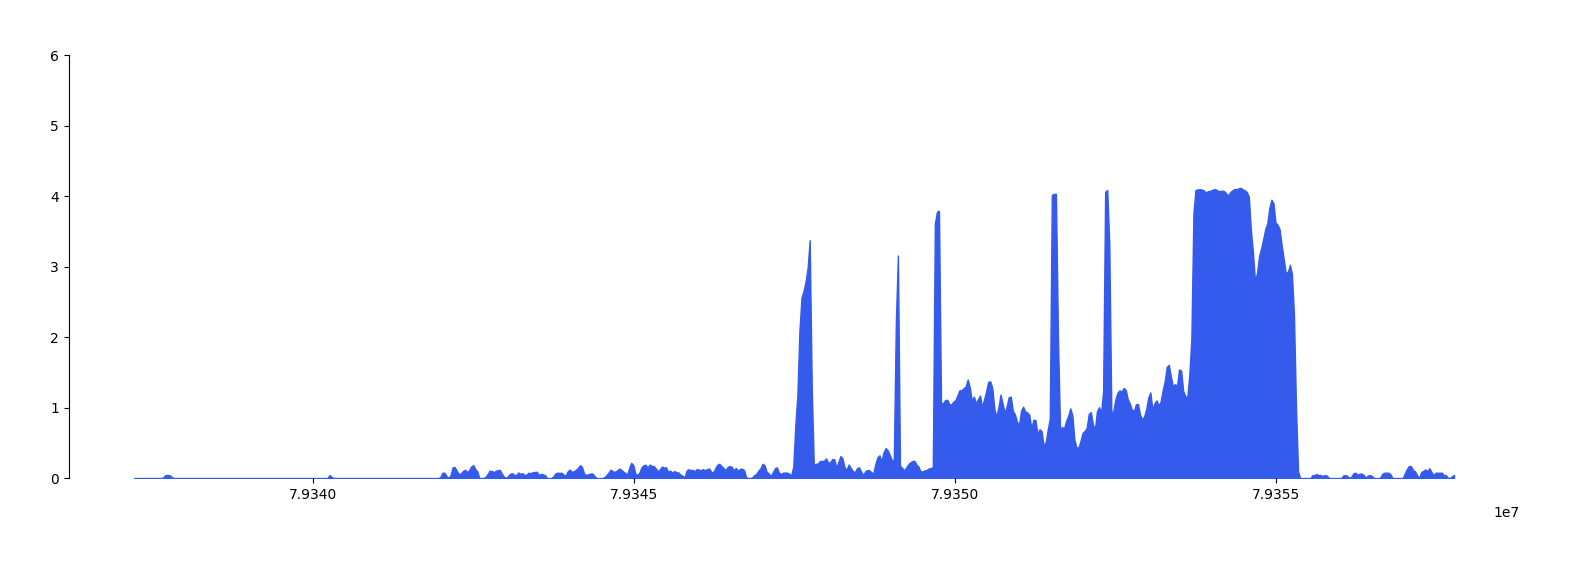

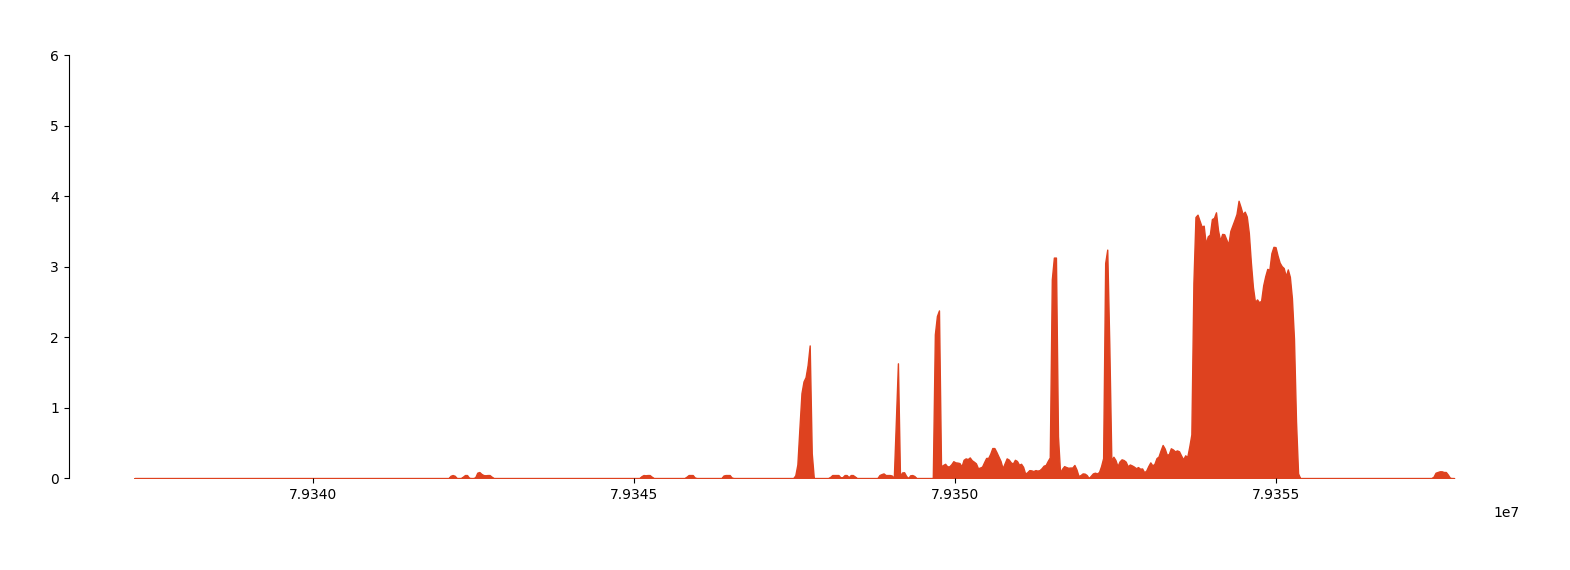

In [25]:
# Target
tasks_to_plot = range(0, 4)
task_names = tasks.description[plot_tasks]
track = np.expand_dims(target[plot_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()].mean(axis=0), axis=0)
print(len(target))

fig = plot_tracks(
    track,
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    figsize=(15,5),            # width, height
    ylim = 6,
    fill_color = '#345beb',
)

tracks = np.expand_dims(target[off_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()].mean(axis=0), axis=0)

fig = plot_tracks(
    tracks,
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    figsize=(15,5),            # width, height
    ylim = 6,
    fill_color = '#de421f'
)

## Plot model predictions

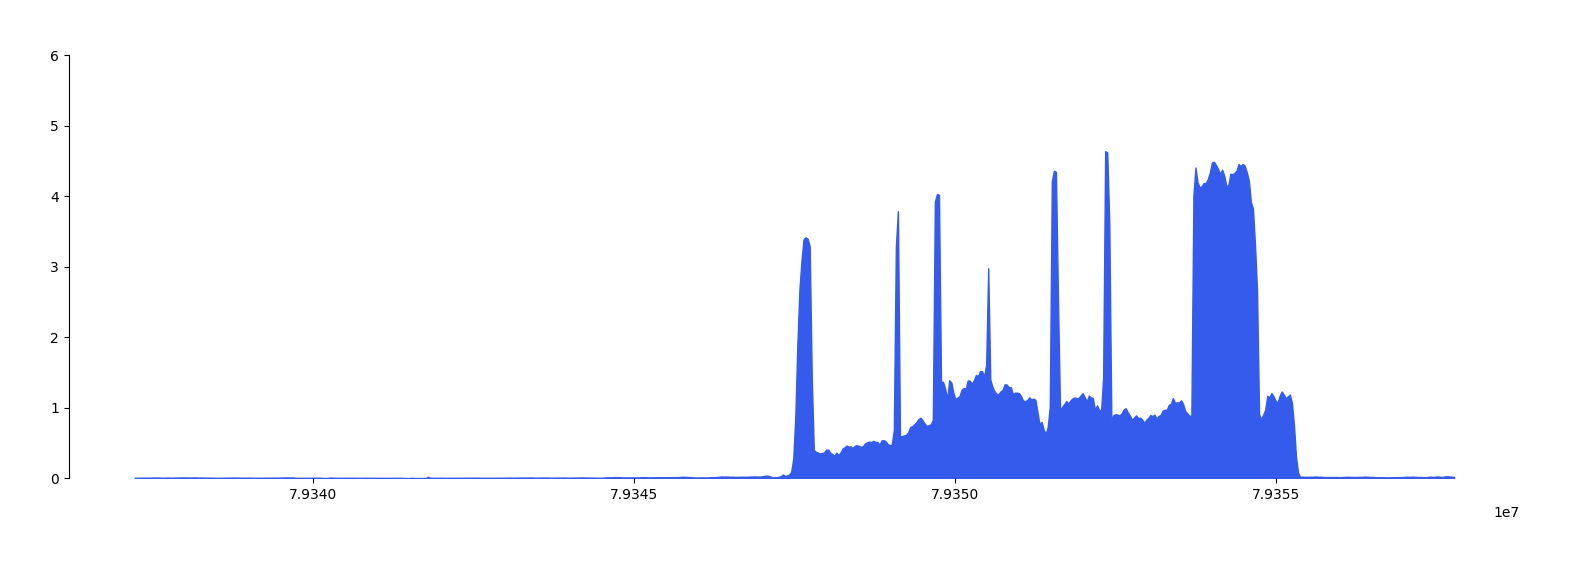

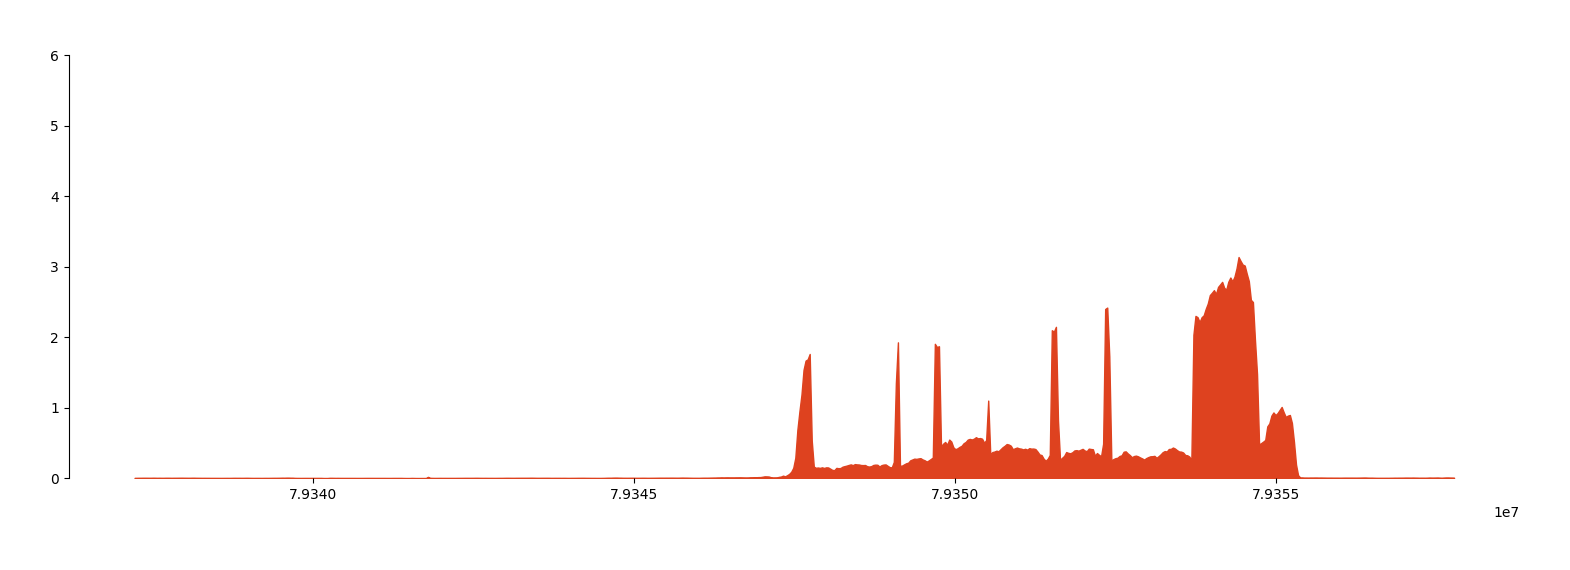

In [26]:
fig = plot_tracks(
    np.expand_dims(preds[plot_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()].mean(axis=0), axis=0),
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    figsize=(15,5),            # width, height
    ylim = 6,
    fill_color = '#345beb',
)

tracks = np.expand_dims(preds[off_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()].mean(axis=0), axis=0)

fig = plot_tracks(
    tracks,
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    figsize=(15,5),            # width, height
    ylim = 6,
    fill_color = '#de421f'
)

### Plot exon annotations

In [27]:
plot_start_coord = 79339864
plot_end_coord = 79359931

promoter_start = 79347211
promoter_end = 79347779

plotF = pd.DataFrame({'chrom': ['chr10'], 'start': [plot_start_coord], 'end': [plot_end_coord]})
plot_bins = model.input_intervals_to_output_bins(
    intervals=plotF,
    start_pos=input_start
)

In [28]:
import grelu.io.genome

exons = grelu.io.genome.read_gtf("hg38", features="exon")

In [29]:
import grelu.data.preprocess

exons = grelu.data.preprocess.filter_overlapping(
    exons,
    ref_intervals=plotF,
    method="all"
)

Keeping 12 intervals


In [30]:
genes = exons[['gene_name', 'chrom', 'strand']].drop_duplicates()
genes = genes.merge(exons.groupby("gene_name").start.min().reset_index())
genes = genes.merge(exons.groupby("gene_name").end.max().reset_index())
genes = genes.rename(columns={"gene_name": "label"})

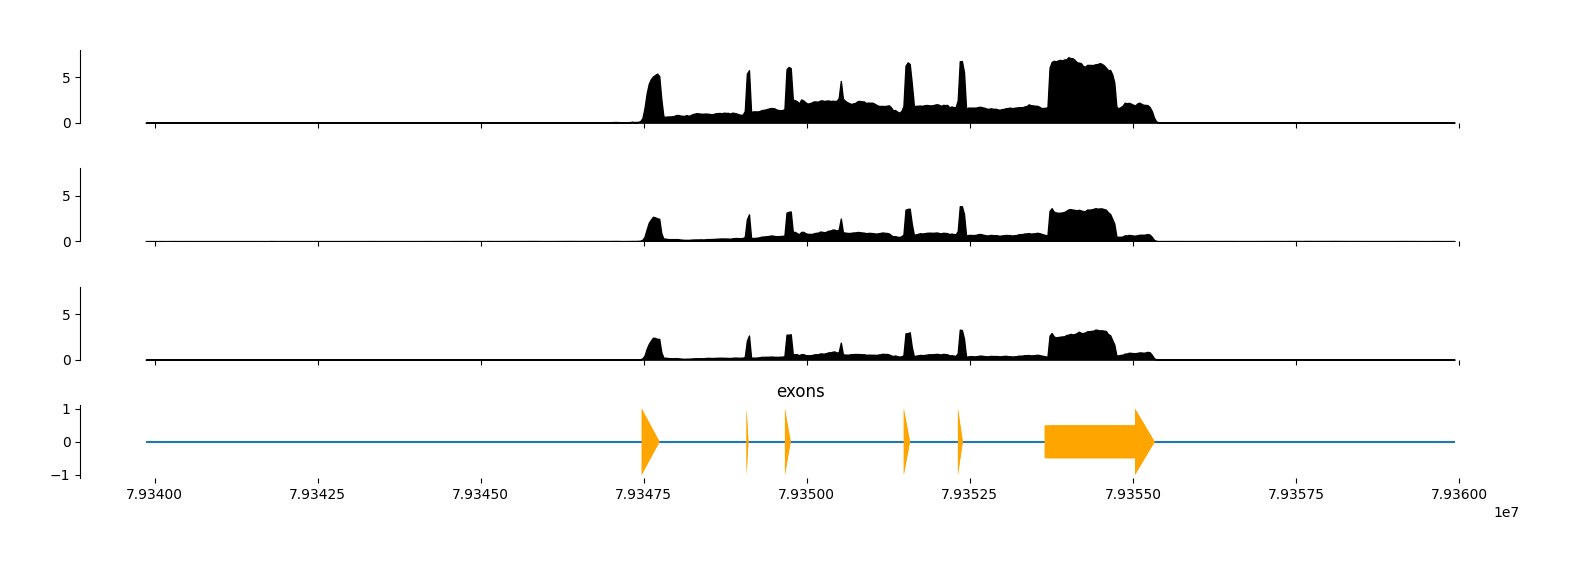

In [31]:
fig = plot_tracks(
    preds[plot_tasks,plot_bins.bin_start.item():plot_bins.bin_end.item()],
    start_pos=plot_bins['start'].item(),  # Start coordinate of the output
    end_pos=plot_bins['end'].item(),      # End coordinate of the output
    #titles=task_names,           # Description of these tracks from the `tasks` dataframe
    figsize=(15,5),            # width, height
    ylim = 8,
    annotations={"exons":exons},
    
)

## Perform ISM across enhancer sequence

In [33]:
import grelu.interpret.score


ism_start_pos = enhancer_start
ism_end_pos = enhancer_end

ppif_exons = exons[exons.gene_name == "PPIF"]
ppif_exons = model.input_intervals_to_output_bins(
    intervals=ppif_exons,
    start_pos=input_start
)

selected_bins = set()
for row in ppif_exons.itertuples():
    selected_bins = selected_bins.union(list(range(row.bin_start, row.bin_end)))

selected_bins = list(selected_bins)

In [34]:
import grelu.transforms.prediction_transforms

blood_ppif_score = grelu.transforms.prediction_transforms.Aggregate(
    tasks = plot_tasks, 
    positions = selected_bins,
    task_aggfunc = "mean",
    length_aggfunc = "sum",
)

In [ ]:
ism = grelu.interpret.score.ISM_predict(
    seqs=input_seq, 
    model=model,
    genome="hg38",
    prediction_transform=blood_ppif_score,
    devices=1, 
    batch_size=4,
    num_workers=1,
    start_pos=ism_start_pos-input_start, # Relative start position from the first base
    end_pos=ism_end_pos-input_start, # Relative end position from the first base
    return_df=True, # Return a dataframe
    compare_func="log2FC", # Return the log2 ratio between the predictions for the mutated sequence and the reference sequence
)


In [35]:
# ism.to_csv('ppif_enhancer_ism_aggregate_july24.csv')
ism = pd.read_csv('ppif_enhancer_ism_aggregate_july24.csv', index_col=0)

In [38]:
def clean_column_name(col):
    return ''.join(re.findall(r'[ACTG]', col))
ism.columns = [clean_column_name(col) for col in ism.columns]

### Plot ISM

<Axes: >

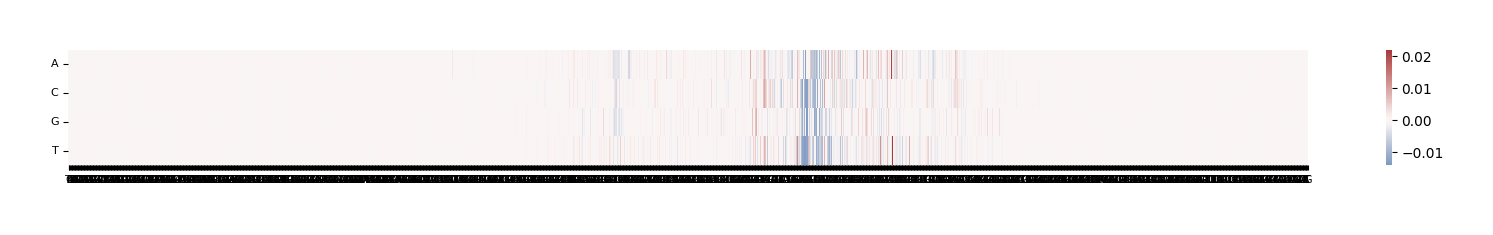

In [41]:
grelu.visualize.plot_ISM(ism, method="heatmap", figsize=(20, 1.5), center=0) 

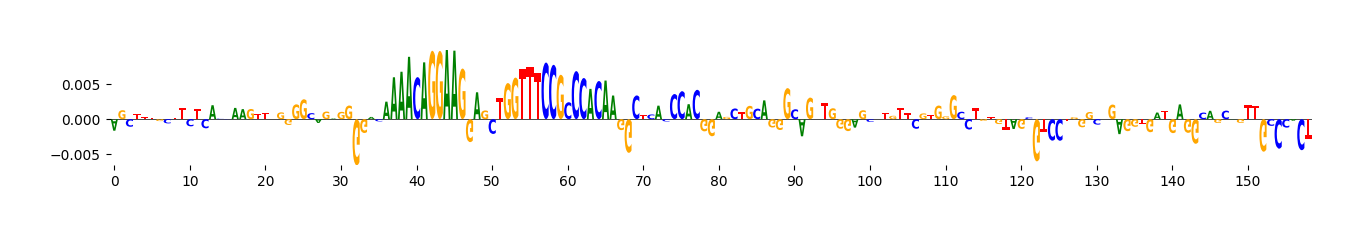

In [42]:
grelu.visualize.plot_ISM(ism, method="logo", figsize=(15.5, 1.5),
                        start_pos=940,end_pos = 1100)

## Evolve enhancer sequence

In [45]:
import grelu.design
from grelu.design import evolve

In [44]:
import grelu.transforms.prediction_transforms

specific_ppif_score = grelu.transforms.prediction_transforms.Specificity(
    on_tasks = plot_tasks, # positive tasks
    off_tasks = off_tasks, # negative tasks
    positions = selected_bins, # The relevant regions of the output
    on_aggfunc = "mean", # Average expression over the positive tasks
    off_aggfunc = "mean", # Average expression over the negative tasks
    length_aggfunc = "mean", # Average expression over the bins
    compare_func = "subtract", # Return the ratio of expression in positive tasks to negative tasks
)

In [46]:
positions = np.arange(enhancer_start, enhancer_end)
positions = positions - input_start

In [47]:
max_iterations = 100

In [ ]:
output = evolve(
    [input_seq], 
    model,
    positions=positions,
    prediction_transform=specific_ppif_score, 
    max_iter=max_iterations,
    num_workers=1,
    devices=1,
    return_seqs="best", # Return all the evolved sequences
    batch_size=4,
    return_preds=False,
)

In [49]:
# output.to_csv('ppif_enhancer_evolution_output_specific_july_30_20round.csv')
output = pd.read_csv('ppif_enhancer_evolution_output_specific_july_30_20round.csv')

### Select best sequence

In [52]:
best_seq = output.sort_values("total_score", ascending=False).iloc[0].seq
best_enhancer = best_seq[enhancer_start - input_start:enhancer_end - input_start] 
out = output[output['best_in_iter']]
starting = out.iloc[0].seq[enhancer_start - input_start:enhancer_end - input_start] 
ending = out.iloc[20].seq[enhancer_start - input_start:enhancer_end - input_start] 

### Plot specificity across evolution 

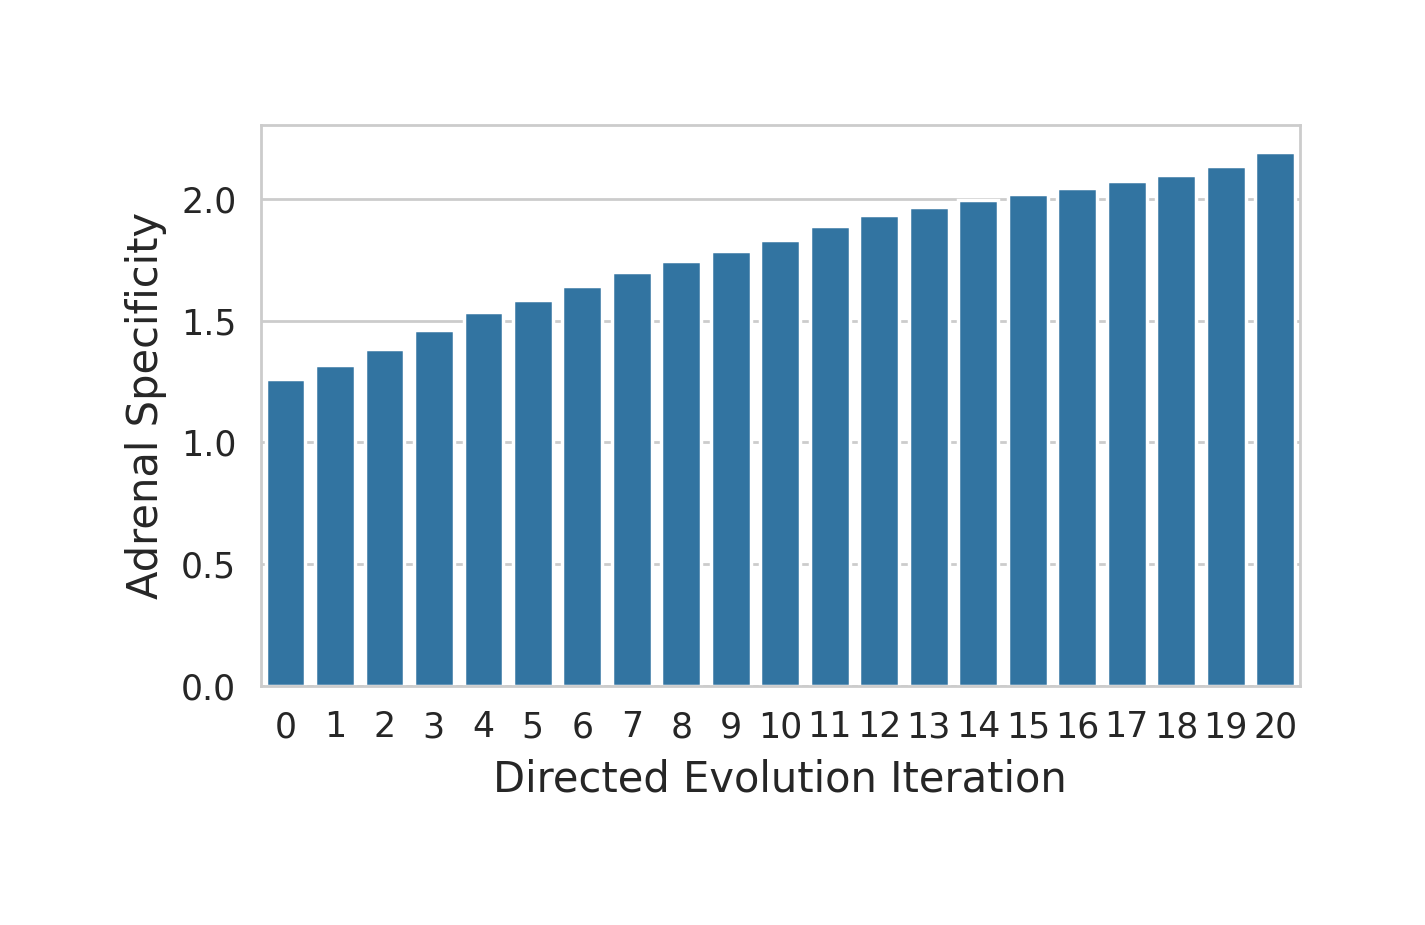

In [53]:
import matplotlib as mpl
sns.set_style("whitegrid")
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True

plt.figure(figsize=(5,3), dpi=250)

# Create the box plot
ax = sns.barplot(data=out, x='iter', y='prediction_score')#, palette='viridis')

# Customize the plot
plt.xlabel('Directed Evolution Iteration', fontsize=12)
plt.ylabel('Adrenal Specificity', fontsize=12)

plt.tight_layout()
plt.show()

## Interpret sequence before and after evolution

In [58]:
better_preds = model.predict_on_seqs([best_seq], device=1)
original_sequence_prediction = model.predict_on_seqs(input_seqs, device=1)

### Define scores

In [55]:
adrenal_ppif_score = grelu.transforms.prediction_transforms.Aggregate(
    tasks = plot_tasks, # positive tasks
    positions = selected_bins, # The relevant regions of the output
    length_aggfunc = "mean", # Average expression over the bins
)

brain_ppif_score = grelu.transforms.prediction_transforms.Aggregate(
    tasks = off_tasks, # positive tasks
    positions = selected_bins, # The relevant regions of the output
    length_aggfunc = "mean", # Average expression over the bins
)

In [59]:
original_adrenal_score = adrenal_ppif_score.compute(original_sequence_prediction).mean()
original_brain_score =  brain_ppif_score.compute(original_sequence_prediction).mean()

edited_adrenal_score = adrenal_ppif_score.compute(better_preds).mean()
edited_brain_score = brain_ppif_score.compute(better_preds).mean()

In [60]:
adrenal_ppif_score.compute(original_sequence_prediction).mean(), brain_ppif_score.compute(original_sequence_prediction).mean()

(2.9867563, 1.7239857)

In [61]:
((edited_adrenal_score - original_adrenal_score) / original_adrenal_score) * 100

25.35397708415985

In [62]:
((edited_brain_score - original_brain_score) / original_brain_score) * 100

-10.100291669368744

### Perform ISM on new sequence

In [ ]:
new_ism = grelu.interpret.score.ISM_predict(
    seqs=best_seq, 
    model=model,
    genome="hg38",
    prediction_transform=blood_ppif_score,
    devices=1, 
    batch_size=4,
    num_workers=1,
    start_pos=ism_start_pos-input_start, # Relative start position from the first base
    end_pos=ism_end_pos-input_start, # Relative end position from the first base
    return_df=True, # Return a dataframe
    compare_func="log2FC", # Return the log2 ratio between the predictions for the mutated sequence and the reference sequence
)

In [71]:
#new_ism.to_csv('new_ism_july31.csv',)
new_ism = pd.read_csv('new_ism_july31.csv', index_col = 0)
new_ism.columns = [clean_column_name(col) for col in new_ism.columns]

<Axes: >

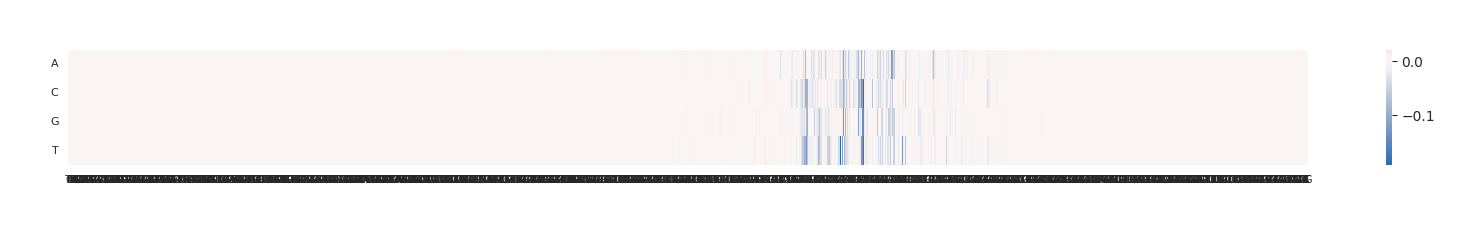

In [73]:
grelu.visualize.plot_ISM(new_ism, method="heatmap", figsize=(20, 1.5), center=0) 

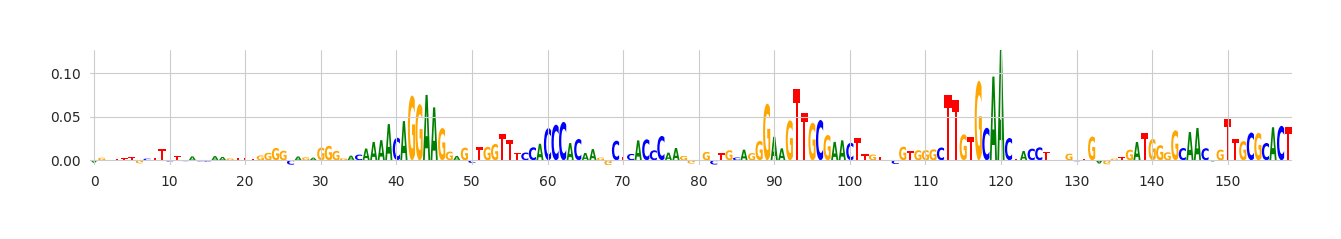

In [74]:
grelu.visualize.plot_ISM(new_ism, method="logo", figsize=(15.5, 1.5),
                        start_pos=940,end_pos = 1100)

## Identify motifs

In [75]:
from grelu.interpret.motifs import scan_sequences
import grelu.interpret.motifs

In [79]:
best_enhancer = best_seq[enhancer_start - input_start:enhancer_end - input_start]
original_enhancer_sequence= input_seq[enhancer_start - input_start:enhancer_end - input_start]

In [80]:
scan = scan_sequences(
        seqs=[original_enhancer_sequence, best_enhancer],
        motifs="jaspar",
        names=None,
        seq_ids=["original", "evolved"],
        pthresh=5e-4,
        rc=True,  
    )

Read 1956 motifs from file.


In [81]:
scan.head()

,motif,sequence,start,end,strand,score,pval
0,Ahr::Arnt,original,747,752,+,11.020408,0.000190
1,Ahr::Arnt,evolved,747,752,+,11.020408,0.000190
2,Ahr::Arnt,original,868,873,+,11.020408,0.000190
3,Ahr::Arnt,evolved,868,873,+,11.020408,0.000190
4,Ahr::Arnt,evolved,835,840,+,10.826531,0.000348
